# Set up the Random See for Numpy & TensorFlow

In [1]:
from tensorflow import set_random_seed
import numpy as np

def set_seeds(s):
    np.random.seed(s)
    set_random_seed(s)

# Generate some data containing outliers

In [2]:
from pyod.utils.data import generate_data

def initialize():
    contamination = 0.1
    n_train = 20000
    n_test = 4000
    n_features = 30
    
    v_XTrain, v_YTrain, v_XTest, v_YTest = generate_data(n_train=n_train, 
                                                 n_features=n_features,
                                                 n_test=n_test,
                                                 contamination=contamination)
    return v_XTrain, v_YTrain, v_XTest, v_YTest

XTrain, YTrain, XTest, YTest = initialize()

C:\MachineLearning\anaconda\lib\site-packages\pyod\utils\data.py:190: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.7.2. Please use behaviour="new", which makes the returned datasets in the order of X_train, X_test, y_train, y_test.
  FutureWarning)


# AutoEncoder Model 

    - This model internally creates an AutoEncoder with the specified Hidden Neurons, Dropout, Epochs etc.
    - We fit only the training data to this model. At this points we assume that all training data is without outliers and hence we can train the model to know 'what good looks like'.
    - However, if it so happens that we know that there are outliers in this data then we can move them into the test data and label them accordingly.

In [3]:
from pyod.models.auto_encoder import AutoEncoder

set_seeds(50)

autoEncoderCLF = AutoEncoder(hidden_activation='relu',
                            #hidden_neurons=[200,100,50,25,50,100,200],
                            hidden_neurons=[50,25,50],
                            output_activation='sigmoid',
                            validation_size=0.2,
                            dropout_rate=0.5,
                            epochs=100,
                            contamination=0.1)

    
autoEncoderCLF.fit(XTrain)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 25)                1275      
__________

18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 59/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 60/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 61/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 62/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 63/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 64/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 65/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 66/100
18000/18000 [==============================] - 1s 33us/step - loss: 1.0031 - val_loss: 0.9722
Epoch 67/100
18000/18000 [========================

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.5, epochs=100,
      hidden_activation='relu', hidden_neurons=[50, 25, 50],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x000001AD556EE2F0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

# Visualizing the training loss of AutoEncoder Model

    - Before we start using the AutoEncoder model and start making predictions about outliers, it's important to see how the underlying AutoEncoder model actually fit the data. 
    - We do so by seeing the loss while fitting the data. As always, we would aim to tweak the layers/neurons/epochs etc. till then time we get good loss

## A) Visualize Loss

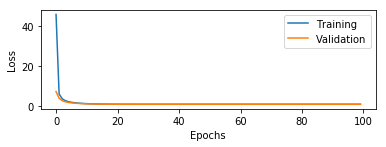

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

history = autoEncoderCLF.history_

figure = plt.figure()

ax1 = figure.add_subplot(211)
ax1.plot(history['loss'])
ax1.plot(history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(labels=['Training','Validation'])

plt.show()

## B) Visualize Loss - Ignoring first 20 Epochs

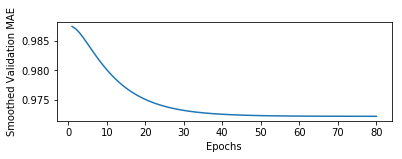

In [5]:
# Plottin validation scores, excluding the first 20 data points

def smooth_curve(points, factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor+point *(1-factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

validation_loss = history['val_loss']
smooth_mae_history = smooth_curve(validation_loss[20:])

figure = plt.figure()
ax1 = figure.add_subplot(211)
ax1.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Smoothed Validation MAE')
plt.show()

# Visualize Outliers

    - Once we are comfortable that the model did minimized the loss we can now visualize the outliers.
    - In this example we are picking up three features and plotting outliers against them. In real life scenario we could do either of the following:
        - Via PCA pick the top 3 features and plot outliers against them.
        - Via Feature Analysis identify top 3 features and plot against them.
    - Idea here is to see if the outlier is able to identify any outliers

# Utility Function - Visualizing Outliers in 3d space

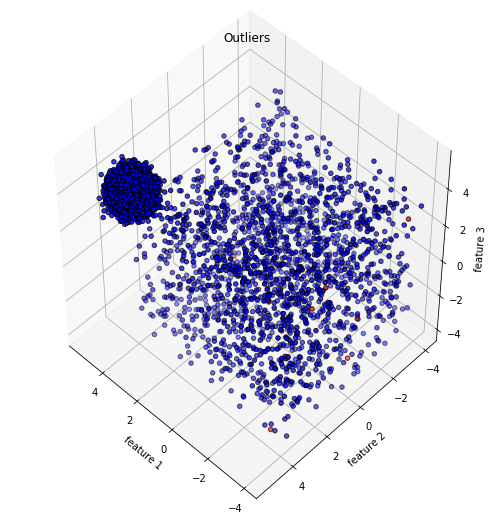

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from pyod.utils.data import evaluate_print

def visualize_outliers (p_TrainX, p_training_scores):
    
    # Find all data points which have a score greater than threshold
    n_outliers = 10
    training_score_as_series = pd.Series(p_training_scores)
    threshold = np.min(training_score_as_series.nlargest(n=n_outliers, keep='first'))
    
    #For visualization pick any three features against which we can plot the outliers. On a real
    #scenario these features would either be derived from PCA or from the dataset itself. These
    #would be the most important features in the dataset.
    df = pd.DataFrame(data=list(zip(p_TrainX[:,1],p_TrainX[:,2],p_TrainX[:,3])), columns=['X1','X2','X3'])
    df['anamoly_scores']=p_training_scores
    df['anamoly'] = (df['anamoly_scores'] >=threshold).astype(int)
    
    colors = {0:'blue', 1:'red'}
    fig = plt.figure(1, figsize=(7,7))
    ax = Axes3D(fig, rect=[0,0,0.95,1], elev=48, azim=134)
    ax.scatter(df['X1'],df['X2'],df['X3'], c= df['anamoly'].apply(lambda x: colors[x]), edgecolors='k')
    ax.set_xlabel('feature 1')
    ax.set_ylabel('feature 2')
    ax.set_zlabel('feature 3')
    plt.title('Outliers')
    plt.show()
    
training_scores = autoEncoderCLF.decision_function(XTrain)
visualize_outliers(XTrain, training_scores)

# Scenario A ->
Evaluate the Outlier scores for training & test data

    - Plot a graph of outlier scores for the training data and for the testing data. This gives us a view of data points where there are clear anamolies

In [7]:
def evaluate_classifier_autoencoder (clf, 
                                     p_x_train, 
                                     p_y_train, 
                                     p_x_test, 
                                     p_y_test):
    
    # get prediction on the training data
    x_train_scores = clf.decision_function(p_x_train)
    
    # for test data get the prediction score- higher score means outlier
    x_test_scores = clf.decision_function(p_x_test)
    
    figure = plt.figure()

    ax1 = figure.add_subplot(211)
    plt.plot(x_train_scores)
    
    ax1 = figure.add_subplot(212)
    plt.plot(x_test_scores)
    
    plt.show()
    
    # for test data check the prediction - outlier or not outlier
    y_test_prediction = clf.predict(p_x_test)

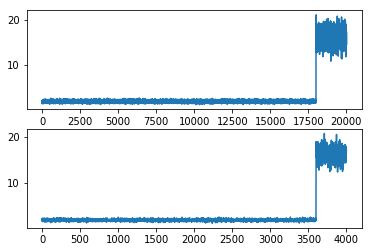

In [8]:
evaluate_classifier_autoencoder(autoEncoderCLF, XTrain, YTrain, XTest, YTest)

# Model Evaluation

## Reconstruction Error Check

    - Autoencoders are trained to reduce reconstruction error which we show below: